In [64]:
#List of all imports
import cv2
import numpy as np
from bs4 import BeautifulSoup
import collections
from itertools import *
from google.colab.patches import cv2_imshow

In [95]:
#Module to read the image
def ReadImages(args):
  image1 = cv2.imread(args[0])
  image2 = cv2.imread(args[1])
  image3 = cv2.imread(args[2])
  image4 = cv2.imread(args[3])
  return image1, image2, image3, image4

def ReadGroundTruth(file):
  with open(file, 'r') as f: 
    data = f.read()
    Bs_data = BeautifulSoup(data, "xml") 
    b_unique = Bs_data.find_all('object')


image1, image2, image3, image4 = ReadImages(['./000009.jpg', './000220.jpg', './002129.jpg', './006919.jpg'])
gt1= ReadGroundTruth('./000009.xml')

#Ground truth bounding boxes
gt1 = [[69, 172, 270, 330], [150, 141, 229, 284], [285, 201, 327, 331], [258, 198, 297, 329]]
gt2 = [[40, 127, 464, 292], [427, 114, 500, 167], [265, 147, 312, 187]]
gt3 = [[106, 50, 256, 122], [110, 95, 280, 176], [126, 142, 323, 236], [167, 194, 408, 313]]
gt4 = [[266, 70, 411, 261],[320, 46, 449, 142],[358, 36, 446, 104],[425, 151, 441, 202],[133, 62, 479, 273],[157, 62, 358, 273], [187, 139, 378, 369], [65, 176, 231, 375], [163, 266, 186, 322], [282, 275, 293, 295]]

In [104]:
#Module which performs Edge Boxes based on given parameters -> returns bounding boxes
def EdgeBoxes(image, model):
  #Create Structure Edge Object
  find_edges = cv2.ximgproc.createStructuredEdgeDetection(model)
  #Convert BGR to RGB
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #Detect Edgemap
  edge_map = find_edges.detectEdges(np.float32(image_rgb) / 255.0)
  #Orientation map
  orientation_map = find_edges.computeOrientation(edge_map)
  #Non-maxima supression on edge map
  edges = find_edges.edgesNms(edge_map, orientation_map)
  #Edge boxe
  edge_boxes = cv2.ximgproc.createEdgeBoxes(alpha = 0.65, beta = 0.7)
  #edge_boxes.setMaxBoxes(100)
  boxes = edge_boxes.getBoundingBoxes(edges, orientation_map)
  boxes, scores = edge_boxes.getBoundingBoxes(edges, orientation_map)
  #Remove from code before submitting
  #cv2_imshow(edge_map*255)
  #cv2_imshow(edges*255)
  #cv2_imshow(orientation_map*255)
  return boxes, scores

model = './structured_edge_model.yml'
boxes, scores = EdgeBoxes(image4, model)
print(len(boxes))

3693


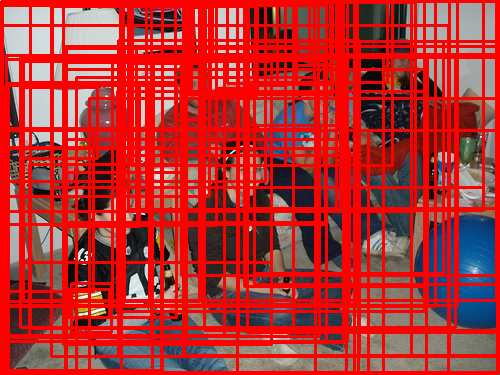

In [79]:
#Draw bounding boxes
def DrawBoundingBoxes(image, boundingBox):
  #Just extract first 100 boundingBoxes
  #boundingBox = boundingBox[0:18]
  #create a copy of the image
  image_copy = np.array(image)
  #iterate over all the region proposals
  for k, bbox in enumerate(boundingBox):
    x, y, w, h = bbox
    #draw rectangles around the region proposals
    cv2.rectangle(image_copy, (int(x), int(y)), (int(x+w) , int(y+h)), (0,0,255), 2)

  return image_copy
image_copy = DrawBoundingBoxes(image2, boxes)
cv2_imshow(image_copy)

133


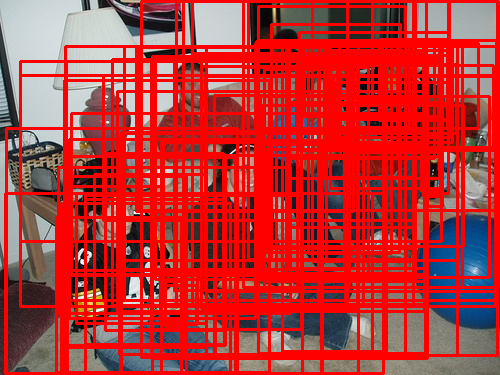

In [105]:
def IoUCalculation(box, gt):
  #Find the area of 2 bounding boxes
  area_box = box[2]*box[3]
  area_gt = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
  union = area_box + area_gt

  #Finding the coordinates of the intersection rectangle
  topX = max(box[0], gt[0])
  topY = max(box[1], gt[1])
  bottomX = min(box[0]+box[2], gt[2])
  bottomY = min(box[1]+box[3], gt[3])
  intersection = max(0, bottomX - topX + 1) * max(0, bottomY - topY + 1)
  IoU = intersection/(union - intersection)
  return IoU

#Loop over all the combinations of gt and bounding boxes to find IoU
IoUList = []
IoUdict = {}
for proposal in boxes:
  for groundTruth in gt4:
    IoU = IoUCalculation(proposal,groundTruth)
    if(IoU > 0.5):
      IoUdict[IoU] = proposal
      IoUList.append(proposal)

print(len(IoUList))
image_copy = DrawBoundingBoxes(image4, IoUList)
cv2_imshow(image_copy)

In [106]:
#Code to find Recall.
count = 0
for groundTruth in gt4:
  for proposal in boxes:
    IoU = IoUCalculation(proposal,groundTruth)
    if(IoU > 0.5):
      count += 1
      break

recall = count/len(gt4)
print(recall)

0.9


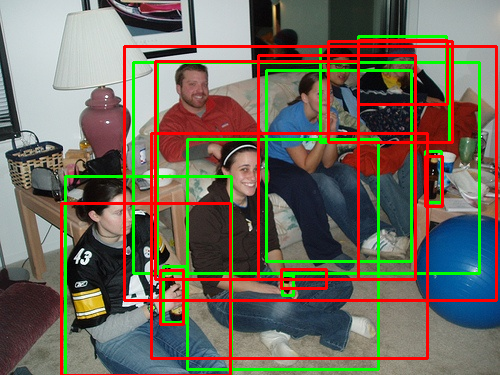

In [107]:
#Comparison with ground truth
final_prediction = []
for groundTruth in gt4:
  bestForObject = {}
  for proposal in boxes:
    IoU = IoUCalculation(proposal,groundTruth)
    bestForObject[IoU] = proposal
  bestForObject_od = collections.OrderedDict(sorted(bestForObject.items(), reverse=True))
  n_items= (list(islice(bestForObject_od.values(), 1)))
  final_prediction.append(n_items[0])

#Draw ground truth and Proposals on the same image
#create a copy of the image
final_image = np.array(image4)
#iterate over all the Ground truths
for k, bbox in enumerate(gt4):
  x, y, w, h = bbox
  #draw rectangles around the region proposals
  cv2.rectangle(final_image, (int(x), int(y)), (int(w) , int(h)), (0,255,0), 2)


#iterate over all the Final Predictions
for k, bbox in enumerate(final_prediction):
  x, y, w, h = bbox
  #draw rectangles around the region proposals
  cv2.rectangle(final_image, (int(x), int(y)), (int(x+w) , int(y+h)), (0,0,255), 2)

cv2_imshow(final_image)